In [1]:
%%time
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score,log_loss, confusion_matrix, auc, roc_auc_score, roc_curve
import keras
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf
import pickle
%matplotlib inline
from PIL import Image
import itertools

Wall time: 6.26 s


## Basic functions for plotting ROC cuves and Confusion Matrixes

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="gold" if cm[i, j] > thresh else "lightgreen")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def plot_roc(y_test, probs):
#     probas = model.predict_proba(X_test)
#     probs = probas[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    # method I: plt
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr,
             color = 'b',
             label = 'AUC = {0}'.format(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Converting Data into python numpy arrays, skip to 'Loading Pickle File's' if you have pickle files

In [5]:
# ../input/
PATH = os.path.abspath(os.path.join('..'))

# ../input/sample/images/
SOURCE_IMAGES = os.path.join(PATH, "images")

# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

In [6]:
images[2]

'C:\\Users\\images\\00000017_001.png'

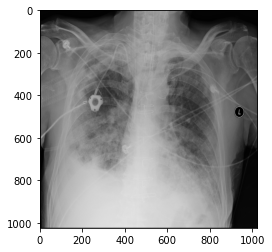

In [7]:
cvimage = cv2.imread(images[10],1)
plt.imshow(cvimage) #cvimage is a numpy array

In [ ]:
Xrays256.shape

In [8]:
#converts all sample images to grayscale 0, then normalizes them, and stores in an numpy array
Xrays256 = np.array([cv2.resize(cv2.imread(img,0), (256, 256), interpolation = cv2.INTER_AREA)/255 for img in images[:]])

In [9]:
Xrays256.shape

(5606, 256, 256)

In [10]:
# Xrays256 = Xrays256.flatten().reshape(5606, 256*256)

In [11]:
# ##not yet
with open('256Xrays.pickle', 'wb') as container:
    pickle.dump(Xrays256, container, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
#next three cells create and encode labels in proper shape
sample_labels = pd.read_csv('sample_labels.csv')
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax',
                  'Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration',
                  'Fibrosis','Pneumonia', 'No Finding']
for pathology in pathology_list:
    sample_labels[pathology] = sample_labels['Finding Labels'].map(lambda x: 1 if pathology in x else 0)

In [13]:
sample_labels.iloc[:,-15:]

,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Finding
0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5602,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
5603,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
binary_labels = sample_labels.iloc[:,-1].values.reshape(-1,1)
multiclass_labels = sample_labels.iloc[:,-15:].values

binary_labels.shape, multiclass_labels.shape

((5606, 1), (5606, 15))

In [15]:
binary_labels = 1-binary_labels

In [16]:
with open('binary_labels.pickle', 'wb') as container:
    pickle.dump(binary_labels, container, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('multiclass_labels.pickle', 'wb') as container:
    pickle.dump(multiclass_labels, container, protocol=pickle.HIGHEST_PROTOCOL)

## Getting Data and Labels from prestored pickle files

In [18]:
# gray scaled to 128 x 128, 256 x 256 change filename to 256Xrays.pickle
with open('256Xrays.pickle', "rb") as input_file:
    xrays = pickle.load(input_file)

In [19]:
with open('binary_labels.pickle', 'rb') as input_file:
    binary_labels = pickle.load(input_file)

In [20]:
binary_labels[0]

array([1], dtype=int64)

In [21]:
xrays.shape
# plt.imshow(Xrays256[100])

(5606, 256, 256)

## train test splitting, and creating batch indices

In [22]:
#using binary labels, so were gonna see if we can predict an abnormality or not!

X_train, X_test, y_train, y_test = train_test_split(xrays, binary_labels, test_size = .2)

In [23]:
#to conserve memory
del xrays

In [24]:
int(np.ceil(len(X_train)/64)) #32 batches

71

In [25]:
#make this a fx with above, def fx(num_batches)

from sklearn.model_selection import train_test_split, KFold

kf = KFold(n_splits=71, shuffle=True, random_state=42)

batches = [train for test, train  in kf.split(X_train, y_train)]
batches[0].shape

(64,)

In [26]:
1122/64

17.53125

In [27]:
kf = KFold(n_splits=18, shuffle=True, random_state=42)

test_batches = [t_batch for _, t_batch  in kf.split(X_test, y_test)]
test_batches[0]

array([  44,   51,   56,   70,   86,   88,   96,  156,  158,  178,  208,
        247,  270,  289,  298,  309,  331,  333,  354,  355,  381,  388,
        432,  477,  478,  485,  494,  522,  526,  534,  545,  548,  599,
        622,  630,  631,  667,  694,  716,  736,  756,  759,  777,  787,
        793,  803,  823,  824,  843,  855,  909,  912,  963,  970,  991,
        997, 1000, 1008, 1055, 1063, 1079, 1086, 1115])

In [59]:
X_train.shape

(4484, 128, 128)

## tensorflow very very simple CNN

In [30]:
#graph
import tensorflow.compat.v1 as tf

tf.compat.v1.reset_default_graph()

tf.disable_v2_behavior()
X = tf.placeholder(dtype = tf.float32,
                   shape = (None, 256, 256), #remember i resized image to 128x128 grayscale using .reshape(-1,128,128,1)
                   name = 'X')

y = tf.placeholder(dtype = tf.float32,
                   shape = (None),
                   name = 'y')

# Input Layer
input_layer = tf.reshape(X, [-1, 128, 128, 1])
                                                                        
# Convolutional Layer #1
out = tf.layers.conv2d(inputs=input_layer,filters=4,
                         kernel_size=[2, 2],
                         padding="same",
                         activation=tf.nn.relu)
# Pooling Layer #1
out = tf.layers.max_pooling2d(inputs=out,
                                pool_size=[2, 2],##64 x 64, strides = 2 so our image is compressed from 128 --> 64
                                    strides=2)
# 2nd Convolutional Layer #2 and Pooling Layer #2
out = tf.layers.conv2d(inputs=out,filters=8,
                         kernel_size=[2, 2],
                         padding="same",
                         activation=tf.nn.relu)
# 2nd Pooling Layer    
out = tf.layers.max_pooling2d(inputs=out,
                                pool_size=[2, 2],#64x64 14 -- >7
                                strides=2)
# 3rd Convolutional Layer
out = tf.layers.conv2d(inputs=out,filters=8,
                         kernel_size=[2, 2],
                         padding="same",
                         activation=tf.nn.relu)
# Dense, dropout, dense Layer
out = tf.reshape(out, [-1, 64 * 64 * 8]) #FLATTEN LAYER
dense = tf.layers.dense(inputs=out, units=100, activation=tf.nn.relu) #FIRST DENSE LAYER
dropout = tf.layers.dropout(inputs=dense,
                            rate=0.2)#40% to zero DROPOUT LAYER
dense2 = tf.layers.dense(inputs=dropout, units=100, activation=tf.nn.relu) #SECOND DENSE LAYER

# Logits Layer
y_hat = tf.layers.dense(inputs=dense2, units=1, #will need to change this once I have more labels/diseases
                        activation = tf.nn.sigmoid)

loss = tf.losses.log_loss(y, y_hat)#gives the loss 

optimizer = tf.train.AdamOptimizer(0.001)

training_op = optimizer.minimize(loss)#optimizes the loss fx with adam gradient descent

saver = tf.train.Saver()

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\PRIYAD~1\AppData\Local\Temp/ipykernel_18016/2801206192.py:19: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  out = tf.layers.conv2d(inputs=input_layer,filters=4,
C:\Users\Priyadharshini A R\anaconda3\lib\site-packages\keras\legacy_tf_layers\convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\PRIYAD~1\AppData\Local\Temp/ipykernel_18016/2801206192.py:24: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  out = tf.layers.max_pooling2d(inputs=out,
C:\Users\Priyadharshini A R\anaconda3\lib\site-packages\keras\legacy_tf_layers\pooling.py:568: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  ret

In [31]:
384/64, X_test.shape

(6.0, (1122, 256, 256))

In [32]:
%%time
#execution phase

init = tf.global_variables_initializer()

test_err = []
train_err = []
pred = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(35): #maybe add some minibatches so it converges faster
        for count, batch in enumerate(batches):
            X_batch = X_train[batch]
            y_batch = y_train[batch]
            sess.run(training_op,
                     feed_dict={X:X_batch, y:y_batch})
            print('epoch:{0}, batch{1}'.format(epoch, count), end='\r')
            
        train_loss = sess.run(loss, feed_dict={X:X_batch, y:y_batch})
        train_err.append(train_loss)
#         test_loss = sess.run(loss, feed_dict={X:X_test, y:y_test})
        
#         test_err.append(test_loss)
       
        print('epoch', epoch, train_loss) #no need for the 'epoch+1', just epoch will suffice
        
    saver.save(sess,'./128Xrays.ckpt')
    
    for batch in test_batches:
        pred.append(sess.run(y_hat, feed_dict={X:X_test[batch]}))

epoch 0 0.64466643
epoch 1 0.6166441
epoch 2 0.6121262
epoch 3 0.61066616
epoch 4 0.6167603
epoch 5 0.60631174
epoch 6 0.5658174
epoch 7 0.5711168
epoch 8 0.5450107
epoch 9 0.43572718
epoch 10, batch7010 0.3018909
epoch 11 0.3247966
epoch 12 0.35344458
epoch 13 0.22837587
epoch 14 0.20323202
epoch 15 0.13413088
epoch 16 0.23223573
epoch 17 0.14338855
epoch 18 0.16363166
epoch 19 0.12366544
epoch 20 0.16353309
epoch 21 0.09538467
epoch 22 0.124134354
epoch 23 0.06715787
epoch 24 0.031116692
epoch 25 0.016211128
epoch 26 0.05730214
epoch 27 0.04203939
epoch 28 0.037543803
epoch 29 0.054673783
epoch 30 0.04637286
epoch 31 0.008837331
epoch 32 0.011099214
epoch 33 0.01166718
epoch 34 0.0065026945
Wall time: 14min 10s


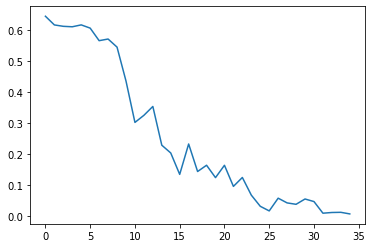

In [33]:
plt.plot(train_err)

In [34]:
predictions = [result for p in pred for result in p ]


In [35]:
predictions[-1]

array([0.04525161], dtype=float32)

In [36]:
from sklearn.metrics import accuracy_score,log_loss #ytrue ypred

log_loss(y_test, [[p[0],1-p[0]] for p in predictions])


3.9472684722159346

In [37]:
np.round([p[0] for p in predictions])

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [38]:
confusion_matrix(y_test, np.round([p[0] for p in predictions]))

array([[347, 273],
       [279, 223]], dtype=int64)

Confusion matrix, without normalization
[[347 273]
 [279 223]]
Normalized confusion matrix
[[0.56 0.44]
 [0.56 0.44]]


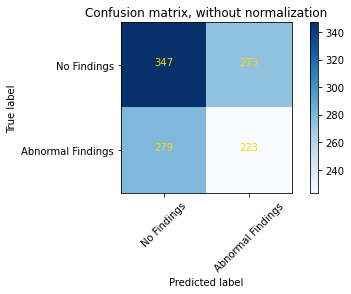

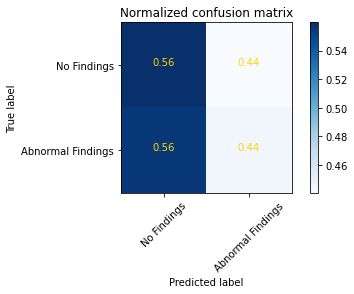

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in predictions]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

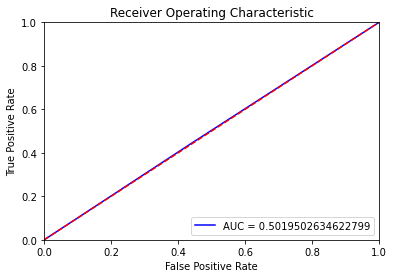

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve
plot_roc(y_test, np.round([p[0] for p in predictions]))

In [41]:
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])


array([[0, 2],
       [1, 1]], dtype=int64)

In [42]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
(tn, fp, fn, tp)

(0, 2, 1, 1)

In [43]:
[[p[0],1-p[0]] for p in predictions]

[[1.0, 0.0],
 [2.1695468e-09, 0.9999999978304532],
 [0.10349506, 0.8965049386024475],
 [0.9879753, 0.01202470064163208],
 [3.88995e-06, 0.9999961100497785],
 [1.1583238e-05, 0.9999884167618802],
 [0.92698896, 0.07301104068756104],
 [0.9449987, 0.05500131845474243],
 [1.7702301e-06, 0.999998229769858],
 [1.9249233e-06, 0.9999980750767463],
 [0.63829684, 0.36170315742492676],
 [0.00015348196, 0.9998465180397034],
 [0.9105513, 0.08944869041442871],
 [3.9597935e-06, 0.9999960402064971],
 [0.99999833, 1.6689300537109375e-06],
 [5.8988913e-05, 0.9999410110867757],
 [8.594622e-05, 0.9999140537765925],
 [0.0018388629, 0.9981611371040344],
 [4.4799398e-10, 0.999999999552006],
 [0.17734769, 0.8226523101329803],
 [0.048237205, 0.9517627954483032],
 [0.9969795, 0.0030205249786376953],
 [0.33757305, 0.6624269485473633],
 [4.1361314e-09, 0.9999999958638686],
 [0.9927975, 0.007202506065368652],
 [0.055871725, 0.9441282749176025],
 [0.99768084, 0.002319157123565674],
 [0.004012078, 0.9959879219532013]

# Transfer Learning comparing the performance of different CNN architecture

## Using 128 x 128 grayscale images

In [44]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  (128,128,1), 
                                 include_top = False, weights = None)
mbnet_model = Sequential()
mbnet_model.add(base_mobilenet_model)
mbnet_model.add(GlobalAveragePooling2D())
mbnet_model.add(Dropout(0.5))
mbnet_model.add(Dense(512))
mbnet_model.add(Dropout(0.5))
mbnet_model.add(Dense(1, activation = 'sigmoid'))

mbnet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mbnet_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                  

In [56]:
X_train = X_train[0:X_train.shape[0],0:128,0:128]
X_test = X_test[0:X_test.shape[0],0:128,0:128]
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [66]:
X_train=X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test=X_test.reshape(X_test.shape[0], 128, 128, 1)

In [64]:
X_train.shape

(4484, 128, 128, 1)

In [67]:
mbnet_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=10,
                        verbose = 1)

Train on 4484 samples
Epoch 1/10
4484/4484 [==============================] - 84s 19ms/sample - loss: 1.0183 - binary_accuracy: 0.5154 - mean_absolute_error: 0.4907
Epoch 2/10
4484/4484 [==============================] - 85s 19ms/sample - loss: 0.8317 - binary_accuracy: 0.5573 - mean_absolute_error: 0.4708
Epoch 3/10
4484/4484 [==============================] - 104s 23ms/sample - loss: 0.7100 - binary_accuracy: 0.5901 - mean_absolute_error: 0.4607
Epoch 4/10
4484/4484 [==============================] - 99s 22ms/sample - loss: 0.6667 - binary_accuracy: 0.6166 - mean_absolute_error: 0.4492
Epoch 5/10
4484/4484 [==============================] - 88s 20ms/sample - loss: 0.6536 - binary_accuracy: 0.6273 - mean_absolute_error: 0.4433
Epoch 6/10
4484/4484 [==============================] - 87s 19ms/sample - loss: 0.6449 - binary_accuracy: 0.6407 - mean_absolute_error: 0.4356
Epoch 7/10
4484/4484 [==============================] - 94s 21ms/sample - loss: 0.6275 - binary_accuracy: 0.6508 - mean

In [68]:
pred_y = mbnet_model.predict(X_test, batch_size = 32, verbose = True)

C:\Users\Priyadharshini A R\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [70]:
score = mbnet_model.evaluate(X_test, y_test, verbose=0)
labels = mbnet_model.metrics_names

C:\Users\Priyadharshini A R\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [71]:
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 0.7579480278938212
binary_accuracy: 0.5516934


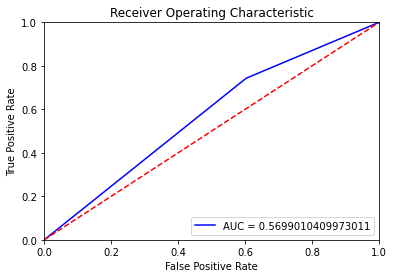

In [72]:
##only trained on 10 epochs. 
plot_roc(y_test, np.round([p[0] for p in pred_y]))

Confusion matrix, without normalization
[[246 374]
 [129 373]]
Normalized confusion matrix
[[0.4  0.6 ]
 [0.26 0.74]]


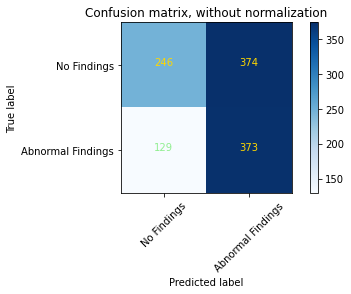

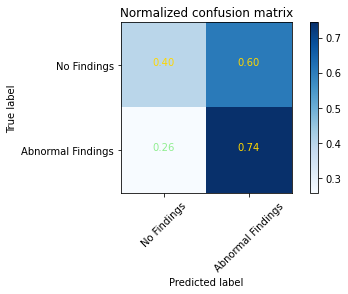

In [73]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [74]:
# Lets train on more epochs, lets do 35

base_mobilenet_model = MobileNet(input_shape =  (128,128,1), 
                                 include_top = False, weights = None)
single_disease_model = Sequential()
single_disease_model.add(base_mobilenet_model)
single_disease_model.add(GlobalAveragePooling2D())
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(512))
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(1, activation = 'sigmoid'))

single_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
single_disease_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [75]:
single_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=30,
                        verbose = 1)

Train on 4484 samples
Epoch 1/30
4484/4484 [==============================] - 91s 20ms/sample - loss: 1.0357 - binary_accuracy: 0.5312 - mean_absolute_error: 0.4832
Epoch 2/30
4484/4484 [==============================] - 91s 20ms/sample - loss: 0.7995 - binary_accuracy: 0.5607 - mean_absolute_error: 0.4717
Epoch 3/30
4484/4484 [==============================] - 97s 22ms/sample - loss: 0.7146 - binary_accuracy: 0.5983 - mean_absolute_error: 0.4578
Epoch 4/30
4484/4484 [==============================] - 96s 21ms/sample - loss: 0.6879 - binary_accuracy: 0.6108 - mean_absolute_error: 0.4551
Epoch 5/30
4484/4484 [==============================] - 91s 20ms/sample - loss: 0.6515 - binary_accuracy: 0.6421 - mean_absolute_error: 0.4402
Epoch 6/30
4484/4484 [==============================] - 86s 19ms/sample - loss: 0.6440 - binary_accuracy: 0.6412 - mean_absolute_error: 0.4395
Epoch 7/30
4484/4484 [==============================] - 82s 18ms/sample - loss: 0.6368 - binary_accuracy: 0.6443 - mean_

In [76]:
pred_y = single_disease_model.predict(X_test, batch_size = 32, verbose = True)
score = single_disease_model.evaluate(X_test, y_test, verbose=0)
labels = single_disease_model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

C:\Users\Priyadharshini A R\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\Priyadharshini A R\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


loss: 1.8506624696513974
binary_accuracy: 0.49376115


Confusion matrix, without normalization
[[219 401]
 [167 335]]
Normalized confusion matrix
[[0.35 0.65]
 [0.33 0.67]]


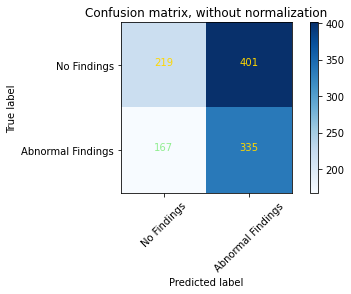

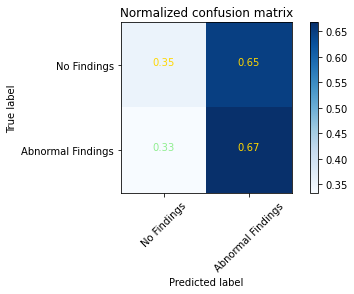

In [77]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

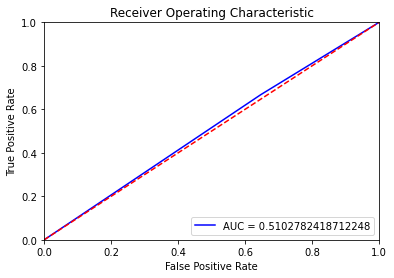

In [78]:
plot_roc(y_test, np.round([p[0] for p in pred_y]))

## lets try in on 256 x 256 grayscale images

In [79]:
with open('256Xrays.pickle', "rb") as input_file:
    xrays = pickle.load(input_file)
    
with open('binary_labels.pickle', 'rb') as input_file:
    binary_labels = pickle.load(input_file)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(xrays, binary_labels, test_size = .2)

In [81]:
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)

### Gray 256 x 256  InceptionV3

In [83]:
base_inc_model = InceptionV3(input_shape=(256,256,1),
                            include_top=False,
                            weights=None)

    
single_disease_model = Sequential()
single_disease_model.add(base_inc_model)
single_disease_model.add(GlobalAveragePooling2D())
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(512))
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(1, activation = 'sigmoid'))

adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

single_disease_model.compile(optimizer = adam, loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
single_disease_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802208  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 513       
                                                      

C:\Users\Priyadharshini A R\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [84]:
single_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=40,
                        verbose = 1)

Train on 4484 samples
Epoch 1/40
4484/4484 [==============================] - 897s 200ms/sample - loss: 1.1287 - binary_accuracy: 0.5281 - mean_absolute_error: 0.4918
Epoch 2/40
4484/4484 [==============================] - 882s 197ms/sample - loss: 0.8170 - binary_accuracy: 0.5368 - mean_absolute_error: 0.4868
Epoch 3/40
4484/4484 [==============================] - 801s 179ms/sample - loss: 0.7778 - binary_accuracy: 0.5678 - mean_absolute_error: 0.4768
Epoch 4/40
4484/4484 [==============================] - 751s 167ms/sample - loss: 0.7570 - binary_accuracy: 0.5727 - mean_absolute_error: 0.4806
Epoch 5/40
4484/4484 [==============================] - 729s 163ms/sample - loss: 0.7262 - binary_accuracy: 0.5981 - mean_absolute_error: 0.4742
Epoch 6/40
4484/4484 [==============================] - 709s 158ms/sample - loss: 0.7108 - binary_accuracy: 0.5979 - mean_absolute_error: 0.4698
Epoch 7/40
4484/4484 [==============================] - 696s 155ms/sample - loss: 0.7027 - binary_accuracy: 

In [27]:
pred_y = single_disease_model.predict(X_test, batch_size = 32, verbose = True)
score = single_disease_model.evaluate(X_test, y_test, verbose=0)
labels = single_disease_model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1122/1122 [==============================] - 13s 12ms/step
loss: 0.6485340210630719
binary_accuracy: 0.6274509803921569


In [1]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

NameError: name 'confusion_matrix' is not defined

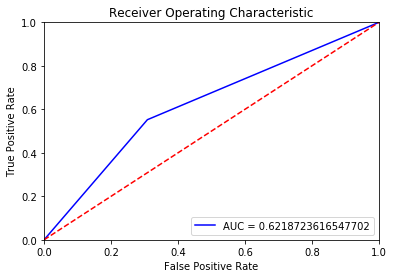

In [29]:
plot_roc(y_test, np.round([p[0] for p in pred_y]))

# 256 x 256 x 3 "color" images

In [7]:
with open('resizedSampleXrays.pickle', "rb") as input_file:
    xrays = pickle.load(input_file)
    
with open('binary_labels.pickle', 'rb') as input_file:
    binary_labels = pickle.load(input_file)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(xrays, binary_labels, test_size = .2)

In [9]:
X_train = X_train.reshape(X_train.shape[0], 256, 256, 3)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 3)

In [15]:
base_vgg_model = VGG16(input_shape=(256,256,3),
                            include_top=False,
                            weights = None)

#                         MobileNet(input_shape =  (128,128,1), 
#                                  include_top = False, weights = None)
    
single_disease_model = Sequential()
single_disease_model.add(base_vgg_model)
single_disease_model.add(GlobalAveragePooling2D())
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(512))
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(1, activation = 'sigmoid'))

adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

single_disease_model.compile(optimizer = adam, loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
single_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
________________________________________________________________

In [16]:
single_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=40,
                        verbose = 1)

Epoch 1/40
4484/4484 [==============================] - 232s 52ms/step - loss: 7.2768 - binary_accuracy: 0.5446 - mean_absolute_error: 0.4547
Epoch 2/40
4484/4484 [==============================] - 176s 39ms/step - loss: 7.3114 - binary_accuracy: 0.5464 - mean_absolute_error: 0.4536
Epoch 3/40
4484/4484 [==============================] - 176s 39ms/step - loss: 7.3114 - binary_accuracy: 0.5464 - mean_absolute_error: 0.4536
Epoch 4/40
4484/4484 [==============================] - 176s 39ms/step - loss: 7.3114 - binary_accuracy: 0.5464 - mean_absolute_error: 0.4536
Epoch 5/40
4484/4484 [==============================] - 176s 39ms/step - loss: 7.3114 - binary_accuracy: 0.5464 - mean_absolute_error: 0.4536
Epoch 6/40
4484/4484 [==============================] - 176s 39ms/step - loss: 7.3114 - binary_accuracy: 0.5464 - mean_absolute_error: 0.4536
Epoch 7/40
4484/4484 [==============================] - 176s 39ms/step - loss: 7.3114 - binary_accuracy: 0.5464 - mean_absolute_error: 0.4536
Epoch 

KeyboardInterrupt: 

In [17]:
pred_y = single_disease_model.predict(X_test, batch_size = 32, verbose = True)
score = single_disease_model.evaluate(X_test, y_test, verbose=0)
labels = single_disease_model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1122/1122 [==============================] - 15s 14ms/step
loss: 7.584986164998851
binary_accuracy: 0.5294117647058824


Confusion matrix, without normalization
[[594   0]
 [528   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


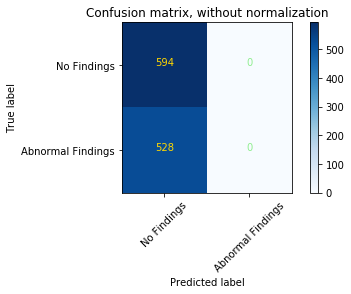

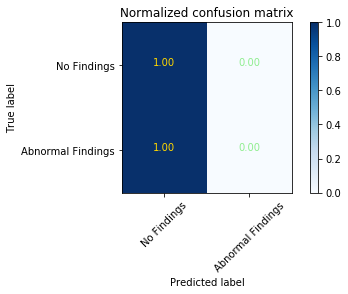

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### "color" MobileNet

In [19]:
base_mobilenet_model = MobileNet(input_shape=(256,256,3),
                            include_top=False,
                            weights = None)

#                         MobileNet(input_shape =  (128,128,1), 
#                                  include_top = False, weights = None)
    
single_disease_model = Sequential()
single_disease_model.add(base_mobilenet_model)
single_disease_model.add(GlobalAveragePooling2D())
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(512))
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(1, activation = 'sigmoid'))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

single_disease_model.compile(optimizer = adam, loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
single_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_256 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 3,754,177
Trainable params: 3,732,289
Non-trainable params: 21,888
_____________________________________________________________

In [20]:
single_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=40,
                        verbose = 1)

Epoch 1/40
4484/4484 [==============================] - 73s 16ms/step - loss: 0.9062 - binary_accuracy: 0.5252 - mean_absolute_error: 0.4843
Epoch 2/40
4484/4484 [==============================] - 69s 15ms/step - loss: 0.7473 - binary_accuracy: 0.5526 - mean_absolute_error: 0.4745
Epoch 3/40
4484/4484 [==============================] - 69s 15ms/step - loss: 0.7032 - binary_accuracy: 0.5747 - mean_absolute_error: 0.4695
Epoch 4/40
4484/4484 [==============================] - 69s 15ms/step - loss: 0.6806 - binary_accuracy: 0.5981 - mean_absolute_error: 0.4611
Epoch 5/40
4484/4484 [==============================] - 69s 15ms/step - loss: 0.6621 - binary_accuracy: 0.6222 - mean_absolute_error: 0.4525
Epoch 6/40
4484/4484 [==============================] - 69s 15ms/step - loss: 0.6496 - binary_accuracy: 0.6334 - mean_absolute_error: 0.4458
Epoch 7/40
4484/4484 [==============================] - 69s 15ms/step - loss: 0.6260 - binary_accuracy: 0.6557 - mean_absolute_error: 0.4302
Epoch 8/40
44

In [21]:
pred_y = single_disease_model.predict(X_test, batch_size = 32, verbose = True)
score = single_disease_model.evaluate(X_test, y_test, verbose=0)
labels = single_disease_model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1122/1122 [==============================] - 7s 6ms/step
loss: 1.3022755067828717
binary_accuracy: 0.5873440285204992


Confusion matrix, without normalization
[[353 241]
 [222 306]]
Normalized confusion matrix
[[0.59 0.41]
 [0.42 0.58]]


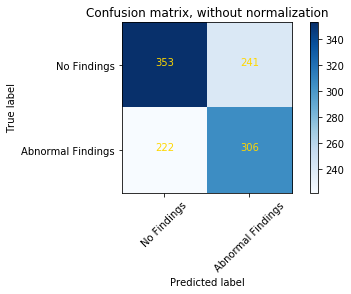

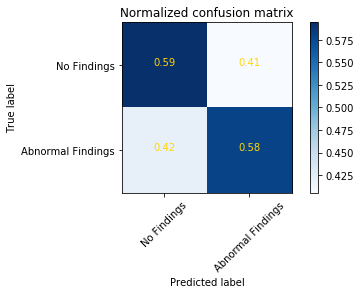

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

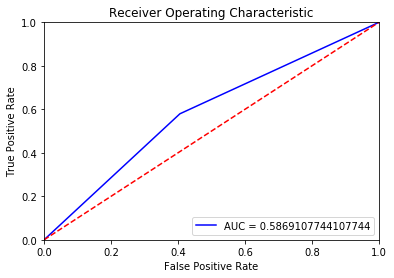

In [23]:
plot_roc(y_test, np.round([p[0] for p in pred_y]))

### "Color" 256 x 256 InceptionV3

In [32]:
X_train.shape

(4484, 256, 256, 3)

In [33]:
base_inc_model = InceptionV3(input_shape=(256,256,3),
                            include_top=False,
                            weights=None)

    
single_disease_model = Sequential()
single_disease_model.add(base_inc_model)
single_disease_model.add(GlobalAveragePooling2D())
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(512))
single_disease_model.add(Dropout(0.5))
single_disease_model.add(Dense(1, activation = 'sigmoid'))

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

single_disease_model.compile(optimizer = adam, loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
single_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 22,852,385
Trainable params: 22,817,953
Non-trainable params: 34,432
___________________________________________________________

In [34]:
single_disease_model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=40,
                        verbose = 1)

Epoch 1/40
4484/4484 [==============================] - 155s 34ms/step - loss: 0.9188 - binary_accuracy: 0.5348 - mean_absolute_error: 0.4818
Epoch 2/40
4484/4484 [==============================] - 134s 30ms/step - loss: 0.8278 - binary_accuracy: 0.5740 - mean_absolute_error: 0.4680
Epoch 3/40
4484/4484 [==============================] - 134s 30ms/step - loss: 0.8662 - binary_accuracy: 0.5859 - mean_absolute_error: 0.4658
Epoch 4/40
4484/4484 [==============================] - 134s 30ms/step - loss: 0.7940 - binary_accuracy: 0.5983 - mean_absolute_error: 0.4601
Epoch 5/40
4484/4484 [==============================] - 134s 30ms/step - loss: 0.7481 - binary_accuracy: 0.6331 - mean_absolute_error: 0.4450
Epoch 6/40
4484/4484 [==============================] - 134s 30ms/step - loss: 0.7437 - binary_accuracy: 0.6224 - mean_absolute_error: 0.4515
Epoch 7/40
4484/4484 [==============================] - 134s 30ms/step - loss: 0.7055 - binary_accuracy: 0.6445 - mean_absolute_error: 0.4387
Epoch 

In [35]:
pred_y = single_disease_model.predict(X_test, batch_size = 32, verbose = True)
score = single_disease_model.evaluate(X_test, y_test, verbose=0)
labels = single_disease_model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1122/1122 [==============================] - 17s 15ms/step
loss: 1.2979732329281521
binary_accuracy: 0.5846702317290553


Confusion matrix, without normalization
[[369 238]
 [228 287]]
Normalized confusion matrix
[[0.61 0.39]
 [0.44 0.56]]


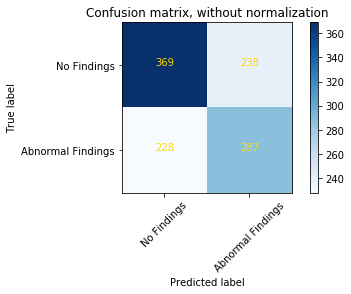

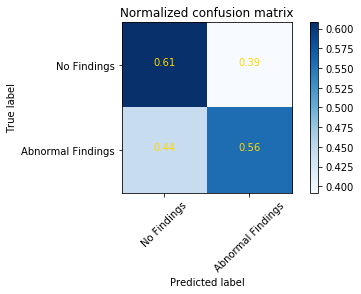

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in pred_y]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

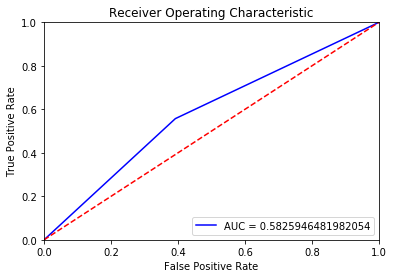

In [37]:
plot_roc(y_test, np.round([p[0] for p in pred_y]))

In [ ]:
plt.imshow(X_test[650])